Configuring

In [182]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import json
import time
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import NaN
df = pd.read_csv("60k.csv")
df.head()

,Unnamed: 0,id,locality,postal_code,region,province,type_of_property,subtype_of_property,type_of_sale,price,...,furnished,open_fire,terrace,terrace_surface,garden,garden_surface,land_surface,number_of_facades,swimming_pool,state_of_the_building
0,0,10131114,HEURE,5377,Wallonie,Namur,HOUSE,HOUSE,residential_sale,100000,...,0,0,1,-1,-1,-1,198,3,-1,TO_RENOVATE
1,1,10150865,Dinant,5500,Wallonie,Namur,APARTMENT,APARTMENT,residential_sale,219000,...,0,0,1,-1,-1,-1,-1,3,-1,GOOD
2,2,10134850,Jemeppe-sur-Sambre Saint-Martin,5190,Wallonie,Namur,HOUSE,APARTMENT_BLOCK,residential_sale,450000,...,-1,0,1,13,1,200,746,4,-1,GOOD
3,3,10022778,Gembloux,5030,Wallonie,Namur,APARTMENT,APARTMENT,residential_sale,285000,...,-1,0,1,6,-1,-1,-1,2,0,AS_NEW
4,4,9989192,Sambreville,5060,Wallonie,Namur,APARTMENT,APARTMENT,residential_sale,284000,...,0,0,1,16,-1,-1,-1,3,0,AS_NEW


DATA CLEANING

In [183]:
def give_info(data):

    info = (pd.concat([data.dtypes,
                   data.nunique(),
                   data.isnull().sum()],axis=1))
    info = info.rename(columns={0:'Data Types',
                            1:'Uniques values', # amount of possible values , 'cardinality' of variable
                            2:'Null Values'}) # amount of null values

    return info
print(give_info(df))
df["number_of_bedrooms"].describe()

                       Data Types  Uniques values  Null Values
Unnamed: 0                  int64           62430            0
id                          int64           62413            0
locality                   object            4395            0
postal_code                 int64            1073            0
region                     object               3            0
province                   object              11            0
type_of_property           object               4            0
subtype_of_property        object              26            0
type_of_sale               object               4            0
price                       int64            5082            0
number_of_bedrooms          int64              47            0
surface                     int64             904            0
kitchen_type               object               9            0
fully_equipped_kitchen     object               8            0
furnished                   int64               3      

count    62430.000000
mean         2.831459
std         11.348917
min         -1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max       2020.000000
Name: number_of_bedrooms, dtype: float64

In [184]:
#Replace the -1 by NaN and calculate the % of NaN value per feature (independant variable)
random_df = df.copy()
random_df = random_df.replace(-1, NaN)
percent_missing = random_df.isnull().sum() * 100 / len(random_df)
print(percent_missing)

Unnamed: 0                 0.000000
id                         0.000000
locality                   0.000000
postal_code                0.000000
region                     0.000000
province                   0.000000
type_of_property           0.000000
subtype_of_property        0.000000
type_of_sale               0.000000
price                      4.806984
number_of_bedrooms         4.552299
surface                   20.623098
kitchen_type               0.000000
fully_equipped_kitchen     0.000000
furnished                 34.246356
open_fire                  0.000000
terrace                   43.499920
terrace_surface           64.706071
garden                    69.468204
garden_surface            80.957873
land_surface              41.866090
number_of_facades         30.864969
swimming_pool             50.709595
state_of_the_building      0.000000
dtype: float64


In [185]:
#drop rows for essential features 
random_df.dropna(subset=["price", "number_of_bedrooms", "surface"], inplace = True)
print(random_df.isna().sum())


Unnamed: 0                    0
id                            0
locality                      0
postal_code                   0
region                        0
province                      0
type_of_property              0
subtype_of_property           0
type_of_sale                  0
price                         0
number_of_bedrooms            0
surface                       0
kitchen_type                  0
fully_equipped_kitchen        0
furnished                 13969
open_fire                     0
terrace                   18087
terrace_surface           29053
garden                    32581
garden_surface            38759
land_surface              20850
number_of_facades         12569
swimming_pool             23603
state_of_the_building         0
dtype: int64


In [186]:
# random_df["swimming_pool", "garden", "terrace", "furnished"].replace(NaN, 0)
random_df = random_df.replace({"swimming_pool":{NaN:0}, "garden":{NaN:0}, "terrace":{NaN:0}, "furnished":{NaN:0}})

In [187]:
print(random_df.isna().sum())

Unnamed: 0                    0
id                            0
locality                      0
postal_code                   0
region                        0
province                      0
type_of_property              0
subtype_of_property           0
type_of_sale                  0
price                         0
number_of_bedrooms            0
surface                       0
kitchen_type                  0
fully_equipped_kitchen        0
furnished                     0
open_fire                     0
terrace                       0
terrace_surface           29053
garden                        0
garden_surface            38759
land_surface              20850
number_of_facades         12569
swimming_pool                 0
state_of_the_building         0
dtype: int64


In [188]:
del random_df["garden_surface"]
del random_df["number_of_facades"]
del random_df["terrace_surface"]
del random_df["land_surface"]

graph_df = random_df[['locality', 'postal_code', 'region', 'province', 'type_of_property', 'subtype_of_property', 'type_of_sale', 'price', 'number_of_bedrooms', 'surface', 'furnished', 'open_fire', 'terrace', 'garden', 'swimming_pool']]

In [189]:
#remove price outliers
for x in ['price']:
  q75, q25 = np.percentile(random_df.loc[:,x],[75,25])
  intr_qr = q75-q25
  max = q75 + (1.5*intr_qr)
  min = q25 - (1.5*intr_qr)


  random_df.loc[random_df[x] < min,x] = np.nan
  random_df.loc[random_df[x] > max,x] = np.nan

/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_4665/3990071794.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Var_Corr = graph_df.corr()


<AxesSubplot: >

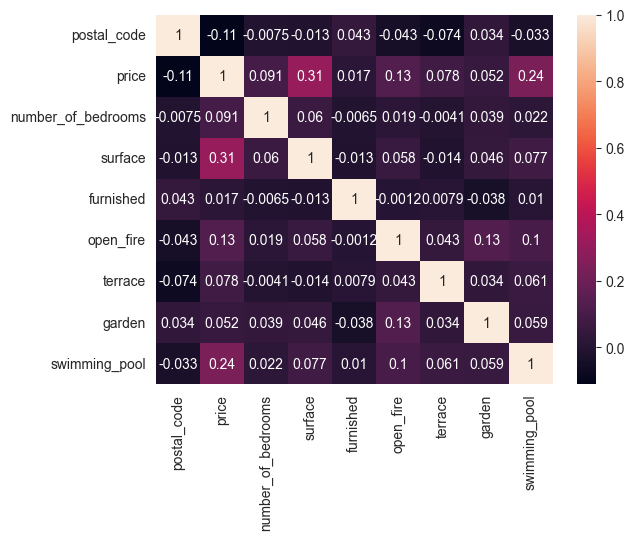

In [190]:
Var_Corr = graph_df.corr()
# plot the heatmap and annotation on it
sb.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)